<a href="https://colab.research.google.com/github/vksriharsha/COMS673-Project/blob/main/Code/PC-CMI_Algorithm/PCA_CMI_Dream3_size10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:

!pip install pycm

     |████████████████████████████████| 65 kB 2.9 MB/s 
     |████████████████████████████████| 574 kB 15.9 MB/s 


In [10]:
import time
import os
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
import itertools
import math
import copy
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from pycm import *

In [11]:
def conditional_mutual_info(X,Y,Z=np.array(1)):
    
    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))
    
    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))
            
    if Z.ndim == 0: 
        c1 = np.cov(X)
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
            
        c2 = np.cov(Y)
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(X,Y)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        cmi = (1/2)*np.log((d1*d2)/d3)
    
    else:
        
        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))
        
        c1 = np.cov(np.concatenate((X, Z), axis=0))
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
    
        c2 = np.cov(np.concatenate((Y, Z), axis=0))
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(Z)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))
        
        if c4.ndim != 0: 
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()
        
        cmi = (1/2)*np.log((d1*d2)/(d3*d4))
    
    
    if math.isinf(cmi):
        cmi = 0
    
    return cmi



In [12]:
def pca_cmi(data, theta, max_order):
    
    genes = list(data.columns)
    
    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    print("Number of edges in the initial complete graph : {}".format(num_edges))
    print()
    
    L = -1
    nochange = False
    
    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)
        
        print("Order : {}".format(L))
        print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
        print()
    
    
    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):
    
    initial_num_edges = predicted_graph.number_of_edges()
    
    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))\
        
        T = len(nhbrs)
        
        if T < L and L != 0:
            continue
        
        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))
            
            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))
                
            K = list(itertools.combinations(nhbrs, L))
                
            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)
                
                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                               
            else:  
                
                maxCmiVal = 0
                
                for zgroup in K:
                    
                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))
                    
                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)
                    
                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal
                
                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                    
                
        
    final_num_edges = predicted_graph.number_of_edges()
        
    if final_num_edges < initial_num_edges:
        return  predicted_graph, False
        
        
    return  predicted_graph, True
            

In [36]:
def print_theta_accuracy(standardnw_path,dataset_path):

  theta_list = [0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]
  acc_value = []
  data = pd.read_csv(dataset_path, sep='\t') 
  data = data.iloc[: , 1:]

  #getting benchmark data from file
  benchmark_network = pd.read_csv(standardnw_path, sep='\t', header=None)
  benchmark_network = benchmark_network.loc[benchmark_network[2] == 1]

  #creating benchmark graph and matrix
  benchmark_graph = nx.Graph()

  for i in (1,10):
      benchmark_graph.add_node('G'+str(i))
  print(benchmark_network.shape)
  for row in range(0,benchmark_network.shape[0]):
      benchmark_graph.add_edge(benchmark_network[0][row], benchmark_network[1][row])


  benchmark_adjMatrix = nx.adjacency_matrix(benchmark_graph)



  for i in theta_list:
    predicted_graph = pca_cmi(data, i, 20)
    predicted_adjMatrix = nx.adjacency_matrix(predicted_graph)



    y_test = benchmark_adjMatrix.todense().flatten()
    y_pred = predicted_adjMatrix.todense().flatten()

    y_pred = np.asarray(y_pred)
    y_test = np.asarray(y_test)

    y_pred = y_pred.reshape(y_pred.shape[1],)
    y_test = y_test.reshape(y_test.shape[1],)

    cm = ConfusionMatrix(y_test, y_pred)
    temp_l = [cm.ACC_Macro, cm.F1_Macro, cm.TPR_Macro, cm.FPR_Macro]
    temp_l = [round(num, 2) for num in temp_l]
    acc_value.append(temp_l)
  
  return theta_list, acc_value;



In [37]:
directory = '/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size10/DREAM3 data/'
df_index = []
for filename in os.listdir(directory):
  if('Yeast' in filename or 'Ecoli' in filename):
    split_filename = (filename.split('-'))
  
    if(split_filename[2] in ['null','nonoise'] ):
      type = split_filename[3].split('.')
      split_mix = split_filename[2]+'-'+type[0]
    else:
      type = split_filename[2].split('.')
      split_mix = type[0]

    df_index.append(split_filename[1]+'-'+split_mix)

df_columns = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# print(len(set(df_index)))
result_df = pd.DataFrame(columns=df_columns, index=df_index)

In [38]:
result_df

,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09
Ecoli1-trajectories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecoli1-heterozygous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecoli1-null-mutants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecoli2-trajectories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecoli2-null-mutants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ecoli2-heterozygous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yeast1-null-mutants,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yeast1-heterozygous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yeast1-trajectories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yeast2-trajectories,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size10/DREAM3 data/InSilicoSize10-Ecoli1-trajectories.tsv
(11, 3)
Number of edges in the initial complete graph : 45

Order : 0
Number of edges in the predicted graph : 31

Order : 1
Number of edges in the predicted graph : 27

Order : 2
Number of edges in the predicted graph : 27



Final Prediction:
-----------------
Order : 2
Number of edges in the predicted graph : 27

Number of edges in the initial complete graph : 45

Order : 0
Number of edges in the predicted graph : 28

Order : 1
Number of edges in the predicted graph : 23

Order : 2
Number of edges in the predicted graph : 19

Order : 3
Number of edges in the predicted graph : 18

Order : 4
Number of edges in the predicted graph : 18



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 18

Number of edges in the initial complete graph : 45

Order : 0
Number of edges in the predicted graph : 25

Order : 1
Number of edges in the pred

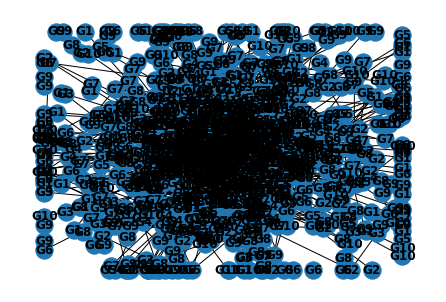

In [53]:

directory = '/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size10/DREAM3 data/'
goldstandard_path = '/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size10/DREAM3 gold standards/'


for filename in os.listdir(directory):
  if('Yeast' in filename or 'Ecoli' in filename):
    dataset_path = directory+filename
    split_filename = (filename.split('-'))

    if(split_filename[2] in ['null','nonoise']):
      type = split_filename[3].split('.')
      split_mix = split_filename[2]+'-'+type[0]
    else:
      type = split_filename[2].split('.')
      split_mix = type[0]

    index_location = split_filename[1]+'-'+split_mix

    goldstandard_name = ('DREAM3GoldStandard_'+split_filename[0]+'_'+split_filename[1]+'.txt')
    standardnw_path = goldstandard_path+goldstandard_name
    print(dataset_path)
    theta_list, acc_value = print_theta_accuracy(standardnw_path,dataset_path)

    for i in range(0, len(theta_list)):
      result_df[theta_list[i]][index_location] = "ACC="+str(acc_value[i][0])+" , F1="+str(acc_value[i][1])+" , TPR="+str(acc_value[i][2])+" , FPR="+str(acc_value[i][3])
    
    result_df.to_csv('/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Size10/DREAM3 data/results10.csv')


In [54]:
result_df

,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09
Ecoli1-trajectories,"ACC=0.52 , F1=0.49 , TPR=0.56 , FPR=0.44","ACC=0.66 , F1=0.59 , TPR=0.62 , FPR=0.38","ACC=0.66 , F1=0.57 , TPR=0.59 , FPR=0.41","ACC=0.68 , F1=0.58 , TPR=0.6 , FPR=0.4","ACC=0.62 , F1=0.52 , TPR=0.53 , FPR=0.47","ACC=0.66 , F1=0.52 , TPR=0.52 , FPR=0.48","ACC=0.68 , F1=0.56 , TPR=0.57 , FPR=0.43","ACC=0.68 , F1=0.56 , TPR=0.57 , FPR=0.43"
Ecoli1-heterozygous,"ACC=0.6 , F1=0.5 , TPR=0.52 , FPR=0.48","ACC=0.66 , F1=0.55 , TPR=0.55 , FPR=0.45","ACC=0.68 , F1=0.56 , TPR=0.57 , FPR=0.43","ACC=0.66 , F1=0.49 , TPR=0.49 , FPR=0.51","ACC=0.68 , F1=0.5 , TPR=0.5 , FPR=0.5","ACC=0.68 , F1=0.46 , TPR=0.47 , FPR=0.53","ACC=0.68 , F1=0.46 , TPR=0.47 , FPR=0.53","ACC=0.7 , F1=0.47 , TPR=0.48 , FPR=0.52"
Ecoli1-null-mutants,"ACC=0.68 , F1=0.6 , TPR=0.63 , FPR=0.37","ACC=0.64 , F1=0.53 , TPR=0.54 , FPR=0.46","ACC=0.68 , F1=0.56 , TPR=0.57 , FPR=0.43","ACC=0.68 , F1=0.56 , TPR=0.57 , FPR=0.43","ACC=0.72 , F1=0.59 , TPR=0.59 , FPR=0.41","ACC=0.7 , F1=0.55 , TPR=0.55 , FPR=0.45","ACC=0.7 , F1=0.55 , TPR=0.55 , FPR=0.45","ACC=0.7 , F1=0.55 , TPR=0.55 , FPR=0.45"
Ecoli2-trajectories,"ACC=0.52 , F1=0.47 , TPR=0.47 , FPR=0.53","ACC=0.56 , F1=0.49 , TPR=0.5 , FPR=0.5","ACC=0.6 , F1=0.52 , TPR=0.52 , FPR=0.48","ACC=0.6 , F1=0.52 , TPR=0.52 , FPR=0.48","ACC=0.56 , F1=0.45 , TPR=0.46 , FPR=0.54","ACC=0.58 , F1=0.47 , TPR=0.47 , FPR=0.53","ACC=0.6 , F1=0.48 , TPR=0.49 , FPR=0.51","ACC=0.62 , F1=0.49 , TPR=0.5 , FPR=0.5"
Ecoli2-null-mutants,"ACC=0.6 , F1=0.58 , TPR=0.62 , FPR=0.38","ACC=0.62 , F1=0.6 , TPR=0.63 , FPR=0.37","ACC=0.6 , F1=0.54 , TPR=0.54 , FPR=0.46","ACC=0.66 , F1=0.59 , TPR=0.59 , FPR=0.41","ACC=0.6 , F1=0.5 , TPR=0.5 , FPR=0.5","ACC=0.6 , F1=0.5 , TPR=0.5 , FPR=0.5","ACC=0.64 , F1=0.53 , TPR=0.53 , FPR=0.47","ACC=0.68 , F1=0.58 , TPR=0.58 , FPR=0.42"
Ecoli2-heterozygous,"ACC=0.62 , F1=0.56 , TPR=0.56 , FPR=0.44","ACC=0.62 , F1=0.54 , TPR=0.54 , FPR=0.46","ACC=0.6 , F1=0.5 , TPR=0.5 , FPR=0.5","ACC=0.54 , F1=0.42 , TPR=0.42 , FPR=0.58","ACC=0.56 , F1=0.43 , TPR=0.44 , FPR=0.56","ACC=0.6 , F1=0.45 , TPR=0.47 , FPR=0.53","ACC=0.64 , F1=0.51 , TPR=0.51 , FPR=0.49","ACC=0.64 , F1=0.51 , TPR=0.51 , FPR=0.49"
Yeast1-null-mutants,"ACC=0.74 , F1=0.61 , TPR=0.61 , FPR=0.39","ACC=0.76 , F1=0.62 , TPR=0.62 , FPR=0.38","ACC=0.8 , F1=0.66 , TPR=0.65 , FPR=0.35","ACC=0.8 , F1=0.66 , TPR=0.65 , FPR=0.35","ACC=0.76 , F1=0.59 , TPR=0.59 , FPR=0.41","ACC=0.76 , F1=0.59 , TPR=0.59 , FPR=0.41","ACC=0.76 , F1=0.59 , TPR=0.59 , FPR=0.41","ACC=0.76 , F1=0.59 , TPR=0.59 , FPR=0.41"
Yeast1-heterozygous,"ACC=0.7 , F1=0.62 , TPR=0.66 , FPR=0.34","ACC=0.72 , F1=0.59 , TPR=0.6 , FPR=0.4","ACC=0.72 , F1=0.53 , TPR=0.53 , FPR=0.47","ACC=0.78 , F1=0.61 , TPR=0.6 , FPR=0.4","ACC=0.7 , F1=0.41 , TPR=0.44 , FPR=0.56","ACC=0.72 , F1=0.42 , TPR=0.45 , FPR=0.55","ACC=0.76 , F1=0.43 , TPR=0.47 , FPR=0.53","ACC=0.76 , F1=0.43 , TPR=0.47 , FPR=0.53"
Yeast1-trajectories,"ACC=0.54 , F1=0.46 , TPR=0.49 , FPR=0.51","ACC=0.58 , F1=0.44 , TPR=0.44 , FPR=0.56","ACC=0.58 , F1=0.41 , TPR=0.4 , FPR=0.6","ACC=0.54 , F1=0.35 , TPR=0.34 , FPR=0.66","ACC=0.58 , F1=0.41 , TPR=0.4 , FPR=0.6","ACC=0.58 , F1=0.41 , TPR=0.4 , FPR=0.6","ACC=0.56 , F1=0.36 , TPR=0.35 , FPR=0.65","ACC=0.56 , F1=0.36 , TPR=0.35 , FPR=0.65"
Yeast2-trajectories,"ACC=0.7 , F1=0.7 , TPR=0.7 , FPR=0.3","ACC=0.66 , F1=0.65 , TPR=0.66 , FPR=0.34","ACC=0.64 , F1=0.62 , TPR=0.64 , FPR=0.36","ACC=0.58 , F1=0.55 , TPR=0.58 , FPR=0.42","ACC=0.64 , F1=0.61 , TPR=0.64 , FPR=0.36","ACC=0.6 , F1=0.57 , TPR=0.6 , FPR=0.4","ACC=0.58 , F1=0.54 , TPR=0.58 , FPR=0.42","ACC=0.62 , F1=0.57 , TPR=0.62 , FPR=0.38"
